In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("aug_train.csv")

In [3]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
# Encode ordinal feature using mapping to transform categorical features into numarical features

# Making Dictionaries of ordinal features

relevent_experience_map = {
    'Has relevent experience':  1,
    'No relevent experience':    0
}

experience_map = {
    '<1'      :    0,
    '1'       :    1, 
    '2'       :    2, 
    '3'       :    3, 
    '4'       :    4, 
    '5'       :    5,
    '6'       :    6,
    '7'       :    7,
    '8'       :    8, 
    '9'       :    9, 
    '10'      :    10, 
    '11'      :    11,
    '12'      :    12,
    '13'      :    13, 
    '14'      :    14, 
    '15'      :    15, 
    '16'      :    16,
    '17'      :    17,
    '18'      :    18,
    '19'      :    19, 
    '20'      :    20, 
    '>20'     :    21
} 
    
last_new_job_map = {
    'never'        :    0,
    '1'            :    1, 
    '2'            :    2, 
    '3'            :    3, 
    '4'            :    4, 
    '>4'           :    5
}

In [5]:
# Transform categorical features into numarical features

def encode(df_pre):
    df_pre.loc[:,'relevent_experience'] = df_pre['relevent_experience'].map(relevent_experience_map)
    df_pre.loc[:,'last_new_job'] = df_pre['last_new_job'].map(last_new_job_map)
    df_pre.loc[:,'experience'] = df_pre['experience'].map(experience_map)
    '''
    #encoding city feature using label encoder
    lb_en = LabelEncoder()

    df_pre.loc[:,'city'] = lb_en.fit_transform(df_pre.loc[:,'city']) 
    '''
    return df_pre

df = encode(df)

# Basic Pipeline

In [7]:
# sets of columns to be transformed in different ways

num_cols = ['city_development_index','relevent_experience', 'experience','last_new_job', 'training_hours']
cat_cols = ['gender', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type']

In [8]:
# Divide train and test sets

from sklearn.model_selection import train_test_split

X = df[num_cols+cat_cols]
y = df['target']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [10]:
# Create pipelines for numerical and categorical features

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [11]:
# Create ColumnTransformer to apply pipeline for each column type

from sklearn.compose import ColumnTransformer

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_cols),
    ('cat_pipeline',cat_pipeline,cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

In [12]:
# Add a model to a final pipeline

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0)

clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])

In [13]:
# Display pipeline

from sklearn import set_config
set_config(display='diagram')

display(clf_pipeline)

# if desired, set display back to the default
# set_config(display='text')

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['city_development_index',
                                                   'relevent_experience',
                                                   'experience', 'last_new_job',
                                                   'training_hours']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender',
                                                   'enrolled_university',
                                                   'education_level',
                                                   'major_discipline',
                                                   'company_size',
                                                   'company_type'])])),
                ('model', LogisticRegression(random_state=0))])

In [15]:
clf_pipeline.get_params()

{'memory': None,
 'steps': [('col_trans', ColumnTransformer(n_jobs=-1,
                     transformers=[('num_pipeline',
                                    Pipeline(steps=[('impute', SimpleImputer()),
                                                    ('scale', MinMaxScaler())]),
                                    ['city_development_index',
                                     'relevent_experience', 'experience',
                                     'last_new_job', 'training_hours']),
                                   ('cat_pipeline',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('one-hot',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    ['gender', 'enroll

In [16]:
# Pass data through Pipeline

clf_pipeline.fit(X_train, y_train)
# preds = clf_pipeline.predict(X_test)
score = clf_pipeline.score(X_test, y_test)
print(f"Model score: {score}")

Model score: 0.7698329853862212


In [18]:
clf_pipeline.predict(X_test)

array([1., 0., 0., ..., 0., 1., 0.])

In [17]:
clf_pipeline.predict_proba(X_test)

array([[0.48131458, 0.51868542],
       [0.86950055, 0.13049945],
       [0.82760719, 0.17239281],
       ...,
       [0.89730924, 0.10269076],
       [0.45044004, 0.54955996],
       [0.91418107, 0.08581893]])

In [13]:
# Get feature name after pipeline (change column names only from one-hot encoder of categorical columns)

new_cat_cols = clf_pipeline.named_steps["col_trans"].named_transformers_["cat_pipeline"]\
                .named_steps["one-hot"].get_feature_names(cat_cols)
all_cols = np.concatenate([num_cols, new_cat_cols])

In [16]:
clf_pipeline.named_steps["col_trans"].named_transformers_["cat_pipeline"]\
                .named_steps["one-hot"].get_feature_names(cat_cols)

array(['gender_Female', 'gender_Male', 'gender_Other',
       'enrolled_university_Full time course',
       'enrolled_university_Part time course',
       'enrolled_university_no_enrollment', 'education_level_Graduate',
       'education_level_High School', 'education_level_Masters',
       'education_level_Phd', 'education_level_Primary School',
       'major_discipline_Arts', 'major_discipline_Business Degree',
       'major_discipline_Humanities', 'major_discipline_No Major',
       'major_discipline_Other', 'major_discipline_STEM',
       'company_size_10/49', 'company_size_100-500',
       'company_size_1000-4999', 'company_size_10000+',
       'company_size_50-99', 'company_size_500-999',
       'company_size_5000-9999', 'company_size_<10',
       'company_type_Early Stage Startup', 'company_type_Funded Startup',
       'company_type_NGO', 'company_type_Other',
       'company_type_Public Sector', 'company_type_Pvt Ltd'], dtype=object)

In [17]:
clf_pipeline.named_steps["col_trans"].named_transformers_["cat_pipeline"]\
                .named_steps["one-hot"].get_feature_names()

array(['x0_Female', 'x0_Male', 'x0_Other', 'x1_Full time course',
       'x1_Part time course', 'x1_no_enrollment', 'x2_Graduate',
       'x2_High School', 'x2_Masters', 'x2_Phd', 'x2_Primary School',
       'x3_Arts', 'x3_Business Degree', 'x3_Humanities', 'x3_No Major',
       'x3_Other', 'x3_STEM', 'x4_10/49', 'x4_100-500', 'x4_1000-4999',
       'x4_10000+', 'x4_50-99', 'x4_500-999', 'x4_5000-9999', 'x4_<10',
       'x5_Early Stage Startup', 'x5_Funded Startup', 'x5_NGO',
       'x5_Other', 'x5_Public Sector', 'x5_Pvt Ltd'], dtype=object)

In [14]:
# Get model coef

coefs = clf_pipeline.named_steps["model"].coef_.flatten()
coef = pd.DataFrame(zip(all_cols, coefs), columns=["feature", "coef"])
coef["abs_coef"] = coef["coef"].apply(lambda x: abs(x))
coef["colors"] = coef["coef"].apply(lambda x: "green" if x > 0 else "red")
coef = coef.sort_values("abs_coef", ascending=False)

Text(0.5, 0, 'Feature Name')

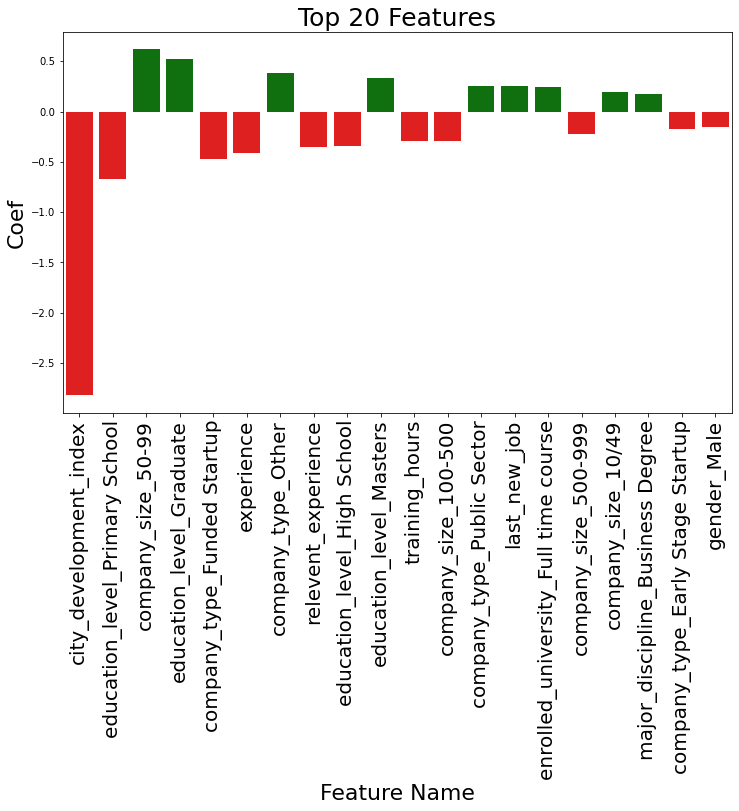

In [15]:
# Plot coef
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="coef",
            data=coef.head(20),
           palette=coef.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

In [16]:
# Dataframe after transform
# pd.DataFrame(col_trans.fit_transform(X_train), columns=all_cols)

In [17]:
# Save pipeline
import joblib

joblib.dump(clf_pipeline,"pipe.joblib")

['pipe.joblib']

In [18]:
# Load pipeline when you want to use
same_pipe = joblib.load("pipe.joblib")

# Add Pipeline to Grid Search

In [11]:
# see parameter that can be tuned

clf_pipeline.get_params()

{'memory': None,
 'steps': [('col_trans', ColumnTransformer(n_jobs=-1,
                     transformers=[('num_pipeline',
                                    Pipeline(steps=[('impute', SimpleImputer()),
                                                    ('scale', MinMaxScaler())]),
                                    ['city_development_index',
                                     'relevent_experience', 'experience',
                                     'last_new_job', 'training_hours']),
                                   ('cat_pipeline',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('one-hot',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    ['gender', 'enroll

In [12]:
clf_pipeline.set_params(model__C = 1)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['city_development_index',
                                                   'relevent_experience',
                                                   'experience', 'last_new_job',
                                                   'training_hours']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender',
                                                   'enrolled_university',
                                                   'education_level',
                                                   'major_discipline',
                                                   'company_size',
                                                   'company_type'])])),
                ('model', LogisticRegression(C=1, random_state=0))])

In [13]:
# Set tuning parameters
 
grid_params = {
    'model__penalty' : ['none', 'l2'],
    'model__C' : np.logspace(-4, 4, 20)
}

In [18]:
# Grid search

from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(clf_pipeline, grid_params, scoring='accuracy')
gs.fit(X_train, y_train)

print("Best Score of train set: "+str(gs.best_score_))
print("Best parameter set: "+str(gs.best_params_))
print("Test Score: "+str(gs.score(X_test,y_test)))

Best Score of train set: 0.7671932014442462
Best parameter set: {'model__C': 0.23357214690901212, 'model__penalty': 'l2'}
Test Score: 0.764874739039666


# Pipeline skip a step

In [19]:
# Add a step 'std_scale' in num_pipeline

from sklearn.preprocessing import StandardScaler

num_pipeline2 = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('minmax_scale',MinMaxScaler()),
    ('std_scale', StandardScaler()),
])

col_trans2 = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline2,num_cols),
    ('cat_pipeline',cat_pipeline,cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

clf_pipeline2 = Pipeline(steps=[
    ('col_trans', col_trans2),
    ('model', clf)
])

In [20]:
clf_pipeline2

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('minmax_scale',
                                                                   MinMaxScaler()),
                                                                  ('std_scale',
                                                                   StandardScaler())]),
                                                  ['city_development_index',
                                                   'relevent_experience',
                                                   'experience', 'last_new_job',
                                                   'training_hours']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender',
                                                   'enrolled_university',
                                                   'education_level',
                                                   'major_discipline',
                                                   'company_size',
                                                   'company_type'])])),
                ('model', LogisticRegression(C=1, random_state=0))])

In [21]:
grid_step_params = [{'col_trans__num_pipeline__minmax_scale': ['passthrough']},
                    {'col_trans__num_pipeline__std_scale': ['passthrough']}]

In [73]:
# Grid search
gs2 = GridSearchCV(clf_pipeline2, grid_step_params, scoring='accuracy')
gs2.fit(X_train, y_train)

print("Best Score of train set: "+str(gs2.best_score_))
print("Best parameter set: "+str(gs2.best_params_))
print("Test Score: "+str(gs2.score(X_test,y_test)))

Best Score of train set: 0.7673233879128983
Best parameter set: {'col_trans__num_pipeline__minmax_scale': 'passthrough'}
Test Score: 0.7700939457202505


In [ ]:
# Both parameter and step

In [24]:
# Set tuning parameters in grid params
# Set step parameters in grid_step_params

grid_params = {'model__penalty' : ['none', 'l2'],
    'model__C' : np.logspace(-4, 4, 20)}

grid_step_params2 = [{**{'col_trans__num_pipeline__minmax_scale': ['passthrough']}, **grid_params},
                    {**{'col_trans__num_pipeline__std_scale': ['passthrough']}, **grid_params}]

# Grid search
gs3 = GridSearchCV(clf_pipeline2, grid_step_params2, scoring='accuracy')
gs3.fit(X_train, y_train)

print("Best Score of train set: "+str(gs3.best_score_))
print("Best parameter set: "+str(gs3.best_params_))
print("Test Score: "+str(gs3.score(X_test,y_test)))

Best Score of train set: 0.7674541064498382
Best parameter set: {'col_trans__num_pipeline__minmax_scale': 'passthrough', 'model__C': 0.012742749857031334, 'model__penalty': 'l2'}
Test Score: 0.7659185803757829


In [25]:
# see all grid search result
pd.DataFrame(gs3.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_col_trans__num_pipeline__minmax_scale,param_model__C,param_model__penalty,param_col_trans__num_pipeline__std_scale,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.114121,0.010730,0.012394,0.008449,passthrough,0.0001,none,NaN,{'col_trans__num_pipeline__minmax_scale': 'pas...,0.765166,0.766721,0.758238,0.769005,0.772920,0.766410,0.004848,13
1,0.064402,0.015003,0.008896,0.007945,passthrough,0.0001,l2,NaN,{'col_trans__num_pipeline__minmax_scale': 'pas...,0.750489,0.750734,0.750734,0.750734,0.750408,0.750620,0.000142,76
2,0.115400,0.009682,0.012973,0.007087,passthrough,0.000264,none,NaN,{'col_trans__num_pipeline__minmax_scale': 'pas...,0.765166,0.766721,0.758238,0.769005,0.772920,0.766410,0.004848,13
3,0.062936,0.000770,0.014201,0.000801,passthrough,0.000264,l2,NaN,{'col_trans__num_pipeline__minmax_scale': 'pas...,0.751142,0.751387,0.751387,0.750734,0.750734,0.751077,0.000294,75
4,0.117991,0.007984,0.013650,0.002279,passthrough,0.000695,none,NaN,{'col_trans__num_pipeline__minmax_scale': 'pas...,0.765166,0.766721,0.758238,0.769005,0.772920,0.766410,0.004848,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.110779,0.009117,0.009378,0.007657,NaN,1438.449888,l2,passthrough,{'col_trans__num_pipeline__std_scale': 'passth...,0.765166,0.766721,0.758238,0.769005,0.772920,0.766410,0.004848,13
76,0.103058,0.008123,0.009548,0.007797,NaN,3792.690191,none,passthrough,{'col_trans__num_pipeline__std_scale': 'passth...,0.765166,0.766721,0.758238,0.769005,0.772920,0.766410,0.004848,13
77,0.088126,0.005611,0.015886,0.002201,NaN,3792.690191,l2,passthrough,{'col_trans__num_pipeline__std_scale': 'passth...,0.765166,0.766721,0.758238,0.769005,0.772920,0.766410,0.004848,13
78,0.093730,0.007722,0.012756,0.006381,NaN,10000.0,none,passthrough,{'col_trans__num_pipeline__std_scale': 'passth...,0.765166,0.766721,0.758238,0.769005,0.772920,0.766410,0.004848,13


# Add custom transformation in a pipeline

In [30]:
# Create custom transformation class

from sklearn.base import TransformerMixin

class Encode(TransformerMixin):
    # Encode ordinal feature using mapping to transform categorical features into numarical features
    def __init__(self):
        print("---------init----------")
        # Making Dictionaries of ordinal features
        self.relevent_experience_map = {
            'Has relevent experience':  1,
            'No relevent experience':    0
        }

        self.experience_map = {
            '<1'      :    0,
            '1'       :    1, 
            '2'       :    2, 
            '3'       :    3, 
            '4'       :    4, 
            '5'       :    5,
            '6'       :    6,
            '7'       :    7,
            '8'       :    8, 
            '9'       :    9, 
            '10'      :    10, 
            '11'      :    11,
            '12'      :    12,
            '13'      :    13, 
            '14'      :    14, 
            '15'      :    15, 
            '16'      :    16,
            '17'      :    17,
            '18'      :    18,
            '19'      :    19, 
            '20'      :    20, 
            '>20'     :    21
        } 

        self.last_new_job_map = {
            'never'        :    0,
            '1'            :    1, 
            '2'            :    2, 
            '3'            :    3, 
            '4'            :    4, 
            '>4'           :    5
        }
        
    def fit(self, df, y = None):
        print("---------fit----------")
        return self
        
    def transform(self, df, y = None):
        print("---------transform----------")
        df_pre = df.copy()
        df_pre.loc[:,'relevent_experience'] = df_pre['relevent_experience'].map(self.relevent_experience_map)
        df_pre.loc[:,'last_new_job'] = df_pre['last_new_job'].map(self.last_new_job_map)
        df_pre.loc[:,'experience'] = df_pre['experience'].map(self.experience_map)
        return df_pre
        

In [31]:
from sklearn.pipeline import Pipeline

encode_pipeline = Pipeline(steps=[('encode', Encode())])

---------init----------


In [32]:
encode_pipeline.fit(df)

---------fit----------


Pipeline(steps=[('encode', <__main__.Encode object at 0x000001D45BA11220>)])

In [33]:
encode_pipeline.transform(df)

---------transform----------


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,1,no_enrollment,Graduate,STEM,21.0,NaN,NaN,1.0,36,1.0
1,29725,city_40,0.776,Male,0,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,5.0,47,0.0
2,11561,city_21,0.624,NaN,0,Full time course,Graduate,STEM,5.0,NaN,NaN,0.0,83,0.0
3,33241,city_115,0.789,NaN,0,NaN,Graduate,Business Degree,0.0,NaN,Pvt Ltd,0.0,52,1.0
4,666,city_162,0.767,Male,1,no_enrollment,Masters,STEM,21.0,50-99,Funded Startup,4.0,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,0,no_enrollment,Graduate,Humanities,14.0,NaN,NaN,1.0,42,1.0
19154,31398,city_103,0.920,Male,1,no_enrollment,Graduate,STEM,14.0,NaN,NaN,4.0,52,1.0
19155,24576,city_103,0.920,Male,1,no_enrollment,Graduate,STEM,21.0,50-99,Pvt Ltd,4.0,44,0.0
19156,5756,city_65,0.802,Male,1,no_enrollment,High School,NaN,0.0,500-999,Pvt Ltd,2.0,97,0.0


# Multiple classifier in a pipeline

In [42]:
# Create custom transformation class

from sklearn.base import TransformerMixin

class Encode(TransformerMixin):
    # Encode ordinal feature using mapping to transform categorical features into numarical
    
    def __init__(self):
        # Making Dictionaries of ordinal features
        self.relevent_experience_map = {
            'Has relevent experience':  1,
            'No relevent experience':    0
        }

    def fit(self, df, y = None):
        return self
        
    def transform(self, df, y = None):
        df_pre = df.copy()
        df_pre.loc[:,'relevent_experience'] = df_pre['relevent_experience'].map(self.relevent_experience_map)
        return df_pre

In [67]:
from sklearn.base import TransformerMixin
class Encode_temp(TransformerMixin):
    # Encode ordinal feature using mapping to transform categorical features into numarical
    
    def __init__(self):
        # Making Dictionaries of ordinal features
        self.rel_exp_map = {
            'Has relevent experience':  1,
            'No relevent experience':    0
        }
    def fit(self, df, y = None):
        return self
        
    def transform(self, df, y = None):
        df_pre = df.copy()
        df_pre.loc[:,'rel_exp'] = df_pre['relevent_experience']\
                               .map(self.rel_exp_map)
        return df_pre

In [43]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression

class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = LogisticRegression()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [46]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('Encode', Encode()),
    ('clf', ClfSwitcher())
])

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = [
    {
        'clf__estimator': [LogisticRegression()], # SVM if hinge loss / logreg if log loss
        'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
        'tfidf__stop_words': ['english', None],
        'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
        'clf__estimator__max_iter': [50, 80],
        'clf__estimator__tol': [1e-4],
        'clf__estimator__loss': ['hinge', 'log', 'modified_huber'],
    },
    {
        'clf__estimator': [SVC(gamma='auto')],
        'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
        'tfidf__stop_words': [None],
        'clf__estimator__alpha': (1e-2, 1e-3, 1e-1),
    },
]

gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, return_train_score=False, verbose=3)
gscv.fit(train_data, train_labels)

# Full pipeline

In [47]:
# Create custom transformation class

from sklearn.base import TransformerMixin

class Encode(TransformerMixin):
    # Encode ordinal feature using mapping to transform categorical features into numarical features
    def __init__(self):
        print("---------init----------")
        # Making Dictionaries of ordinal features
        self.relevent_experience_map = {
            'Has relevent experience':  1,
            'No relevent experience':    0
        }

        self.experience_map = {
            '<1'      :    0,
            '1'       :    1, 
            '2'       :    2, 
            '3'       :    3, 
            '4'       :    4, 
            '5'       :    5,
            '6'       :    6,
            '7'       :    7,
            '8'       :    8, 
            '9'       :    9, 
            '10'      :    10, 
            '11'      :    11,
            '12'      :    12,
            '13'      :    13, 
            '14'      :    14, 
            '15'      :    15, 
            '16'      :    16,
            '17'      :    17,
            '18'      :    18,
            '19'      :    19, 
            '20'      :    20, 
            '>20'     :    21
        } 

        self.last_new_job_map = {
            'never'        :    0,
            '1'            :    1, 
            '2'            :    2, 
            '3'            :    3, 
            '4'            :    4, 
            '>4'           :    5
        }
        
    def fit(self, df, y = None):
        print("---------fit----------")
        return self
        
    def transform(self, df, y = None):
        print("---------transform----------")
        df_pre = df.copy()
        df_pre.loc[:,'relevent_experience'] = df_pre['relevent_experience'].map(self.relevent_experience_map)
        df_pre.loc[:,'last_new_job'] = df_pre['last_new_job'].map(self.last_new_job_map)
        df_pre.loc[:,'experience'] = df_pre['experience'].map(self.experience_map)
        return df_pre

In [48]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = LogisticRegression()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [49]:
# sets of columns to be transformed in different ways

num_cols = ['city_development_index','relevent_experience', 'experience','last_new_job', 'training_hours']
cat_cols = ['gender', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type']

In [50]:
# Divide train and test sets

from sklearn.model_selection import train_test_split

X = df[num_cols+cat_cols]
y = df['target']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [51]:
# Create pipelines for numerical and categorical features

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [52]:
# Create ColumnTransformer to apply pipeline for each column type

from sklearn.compose import ColumnTransformer

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_cols),
    ('cat_pipeline',cat_pipeline,cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

In [57]:
# Add a model to a final pipeline

full_pipeline = Pipeline(steps=[
    ('Encode', Encode()),
    ('col_trans', col_trans),
    ('model', ClfSwitcher())
])

---------init----------


In [59]:
# Display pipeline

from sklearn import set_config
set_config(display='diagram')

display(full_pipeline)

# if desired, set display back to the default
# set_config(display='text')

Pipeline(steps=[('Encode', <__main__.Encode object at 0x0000021361818130>),
                ('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['city_development_index',
                                                   'relevent_experience',
                                                   'experience', 'last_new_job',
                                                   'training_hours']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender',
                                                   'enrolled_university',
                                                   'education_level',
                                                   'major_discipline',
                                                   'company_size',
                                                   'company_type'])])),
                ('model', ClfSwitcher())])

In [61]:
grid_params = [
    {'model__estimator': [LogisticRegression()]},
    {'model__estimator': [SVC(gamma='auto')]}
]

In [62]:
# Grid search

from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(full_pipeline, grid_params, scoring='accuracy')
gs.fit(X_train, y_train)

print("Best Score of train set: "+str(gs.best_score_))
print("Best parameter set: "+str(gs.best_params_))
print("Test Score: "+str(gs.score(X_test,y_test)))

---------fit----------
---------transform----------
---------transform----------
---------fit----------
---------transform----------
---------transform----------
---------fit----------
---------transform----------
---------transform----------
---------fit----------
---------transform----------
---------transform----------
---------fit----------
---------transform----------
---------transform----------
---------fit----------
---------transform----------
---------transform----------
---------fit----------
---------transform----------
---------transform----------
---------fit----------
---------transform----------
---------transform----------
---------fit----------
---------transform----------
---------transform----------
---------fit----------
---------transform----------
---------transform----------
---------fit----------
---------transform----------
Best Score of train set: 0.7654964782400032
Best parameter set: {'model__estimator': LogisticRegression()}
---------transform----------
Te

In [63]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.806500,0.863156,0.525082,0.623519,LogisticRegression(),{'model__estimator': LogisticRegression()},0.766471,0.762153,0.767700,0.759869,0.771289,0.765496,0.004054,1
1,4.403474,0.382040,1.655230,0.058941,SVC(gamma='auto'),{'model__estimator': SVC(gamma='auto')},0.753098,0.749103,0.740946,0.753670,0.756281,0.750620,0.005355,2
